In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


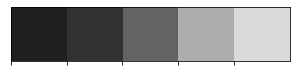

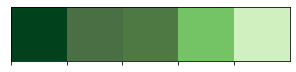

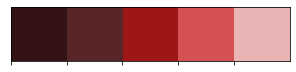

In [19]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [14]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor'] 

In [17]:
X_train = []
y_train = []
image_size = 128
for i in labels:
    folderPath = os.path.join(r'D:/classification/','Training',i)
    for j in (os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(r'D:/classification/','Testing',i)
    for j in (os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)


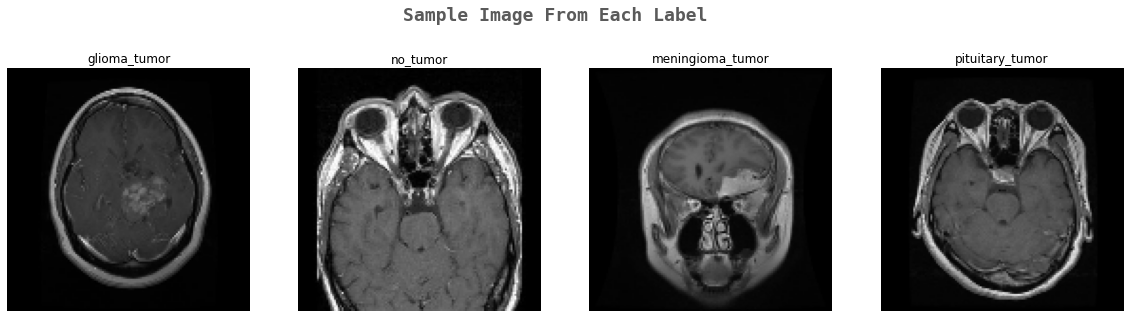

In [20]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [21]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [22]:
X_train.shape

(3264, 128, 128, 3)

In [23]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(3264, 128, 128, 3)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [26]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [28]:
from tensorflow.keras.applications import ResNet152V2
resnet = ResNet152V2(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

In [31]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']       

In [33]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [34]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet152v1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [35]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =25, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

C:\Users\Admin\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.6833 
Epoch 00001: val_accuracy improved from -inf to 0.15849, saving model to resnet152v1.h5
75/75 [==============================] - 1012s 13s/step - loss: 0.8212 - accuracy: 0.6833 - val_loss: 17.4859 - val_accuracy: 0.1585 - lr: 0.0010
Epoch 2/25
75/75 [==============================] - ETA: 0s - loss: 0.4855 - accuracy: 0.8310 
Epoch 00002: val_accuracy improved from 0.15849 to 0.51321, saving model to resnet152v1.h5
75/75 [==============================] - 840s 11s/step - loss: 0.4855 - accuracy: 0.8310 - val_loss: 2.7706 - val_accuracy: 0.5132 - lr: 0.0010
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8860 
Epoch 00003: val_accuracy did not improve from 0.51321
75/75 [==============================] - 880s 12s/step - loss: 0.3279 - accuracy: 0.8860 - val_loss: 19.9131 - val_accuracy: 0.3245 - lr: 0.0010
Epoch 4/25
75/75 [============================

In [38]:
train_dir = "D:\classification\Training"
test_dir = "D:\classification\Testing"

In [39]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(128,128),
                                                                 label_mode = "categorical",
                                                                 batch_size = 32
                                                                 )
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size =(128,128),
                                                               label_mode = "categorical",
                                                               batch_size = 32
                                                               )

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [40]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [41]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        73
           1       0.96      0.96      0.96        46
           2       0.96      0.90      0.93        90
           3       0.95      0.99      0.97        85

    accuracy                           0.94       294
   macro avg       0.94      0.94      0.94       294
weighted avg       0.94      0.94      0.94       294



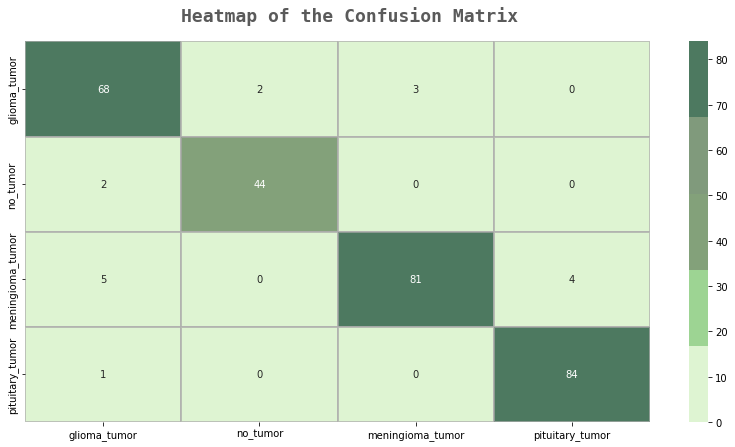

In [42]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [43]:
# tunning the model
resnet.trainable = True

for layer in resnet.layers[:-1]:
  resnet.trainable = False

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']       

In [45]:
h_t=model.fit(train_data,
          epochs = 10,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data)
          )

Epoch 1/10
90/90 [==============================] - 310s 3s/step - loss: 1.3112 - accuracy: 0.8160 - val_loss: 0.1755 - val_accuracy: 0.9594
Epoch 2/10
90/90 [==============================] - 287s 3s/step - loss: 0.0438 - accuracy: 0.9882 - val_loss: 0.1690 - val_accuracy: 0.9594
Epoch 3/10
90/90 [==============================] - 288s 3s/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.1899 - val_accuracy: 0.9518
Epoch 4/10
90/90 [==============================] - 287s 3s/step - loss: 0.0322 - accuracy: 0.9882 - val_loss: 0.2193 - val_accuracy: 0.9391
Epoch 5/10
90/90 [==============================] - 287s 3s/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.2558 - val_accuracy: 0.9112
Epoch 6/10
90/90 [==============================] - 288s 3s/step - loss: 0.0310 - accuracy: 0.9895 - val_loss: 0.2716 - val_accuracy: 0.9112
Epoch 7/10
90/90 [==============================] - 288s 3s/step - loss: 0.0284 - accuracy: 0.9906 - val_loss: 0.2725 - val_accuracy: 0.9086
Epoch 8/10
90

In [46]:
# evaluatinn the model
model_evaluation = model.evaluate(test_data)

13/13 [==============================] - 35s 3s/step - loss: 0.3270 - accuracy: 0.8883


C:\Users\Admin\AppData\Local\Temp/ipykernel_12220/1500263093.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


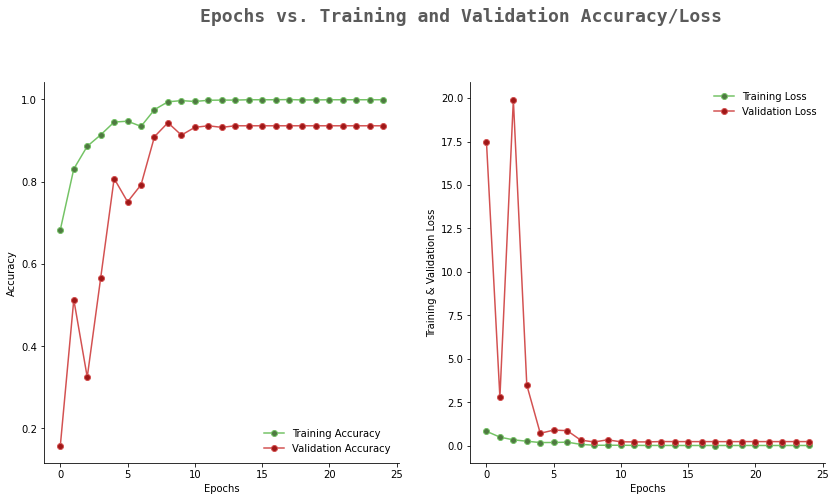

In [47]:
epochs = [i for i in range(25)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

C:\Users\Admin\AppData\Local\Temp/ipykernel_12220/2429489945.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


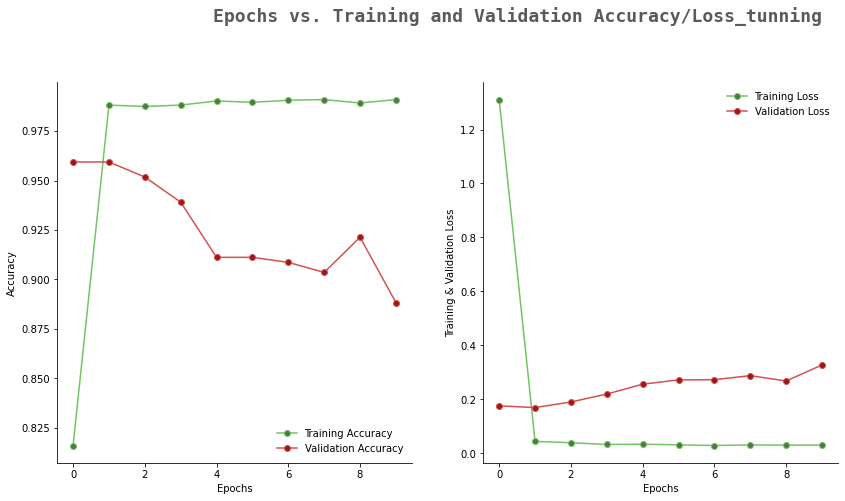

In [48]:
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = h_t.history['accuracy']
train_loss = h_t.history['loss']
val_acc = h_t.history['val_accuracy']
val_loss = h_t.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss_tunning',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()


In [49]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [50]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        73
           1       0.02      0.04      0.03        46
           2       0.00      0.00      0.00        90
           3       0.99      0.99      0.99        85

    accuracy                           0.52       294
   macro avg       0.49      0.49      0.49       294
weighted avg       0.53      0.52      0.52       294



In [52]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')